# Show restaurants and select the best one

In [1]:
import pandas as pd
import numpy as np
import pandas_gbq as gbq 
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# hide warnings. `gbq.read_gbq()` gives some
import warnings
warnings.filterwarnings('ignore')

In [2]:
# project specifics
PRIVATE_KEY = '../google-credentials/gsdk-credentials.json'
PROJECT_ID = json.load(open(PRIVATE_KEY))['project_id']

In [12]:
# Comments
city = 'amsterdam'
date = '20180123'
bq_table_comments = '_'.join(['iens.iens_comments', city, date])

In [79]:
# Restaurants info
city = 'amsterdam'
date = '20171228'
bq_table_restaurants = '_'.join(['iens.iens', city, date])

## Reading from BigQuery

To load a BigQuery table into a Pandas dataframe, all you need is a query, the project_id, and a way to authenticate.

In [14]:
query = "SELECT * FROM {}".format(bq_table_comments)
comments = gbq.read_gbq(query, project_id=PROJECT_ID, private_key=PRIVATE_KEY)

Requesting query... ok.
Job ID: job_Bag-pwTULOcXWW60r5nqxX5ssi8b
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 42% done. Elapsed 13.01 s.
  Got page: 3; 68% done. Elapsed 18.7 s.
  Got page: 4; 86% done. Elapsed 26.89 s.
  Got page: 5; 100% done. Elapsed 31.06 s.
Got 94854 rows.

Total time taken 32.56 s.
Finished at 2018-03-09 13:56:37.


In [15]:
comments.shape

(94854, 10)

In [175]:
query_restaurants = "SELECT info.*, reviews.*, tags FROM {}".format(bq_table_restaurants)
restaurants = (
    gbq
    .read_gbq(query_restaurants, project_id=PROJECT_ID, private_key=PRIVATE_KEY)
    .set_index('info_id')
)   

Requesting query... ok.
Job ID: job_gPJM1kXbn2mdZhJiSY8wMvigyg9l
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 100% done. Elapsed 7.91 s.
Got 20939 rows.

Total time taken 8.76 s.
Finished at 2018-03-09 15:58:16.


In [176]:
restaurants.shape

(20939, 24)

## Merge duplicated restaurants (one row for each tag)

In [178]:
len(
    restaurants
    .groupby([x for x in restaurants.columns if x != 'tags'])
)

2827

In [139]:
restaurants.loc[lambda r: r['tags'].isnull()]

,info_avg_price,info_city,info_country,info_house_number,info_id,info_lat,info_lon,info_name,info_postal_code,info_street,...,reviews_nr_8ratings,reviews_nr_9ratings,reviews_nr_ratings,reviews_price_quality,reviews_rating_decor,reviews_rating_food,reviews_rating_service,reviews_rating,reviews_waiting_time,tags
14501,-1,Amsterdam,Nederland,2,324947,52.338247,4.920366,JUNIPER & KIN,1096GG,Amstelvlietstraat,...,-1,-1,-1,None,-1.0,-1.0,-1.0,-1.0,None,None


In [179]:
def makelist(x):
    return list(x)

In [181]:
tag_list = (
    restaurants
    .groupby('info_id')
    .agg({'tags': makelist})
)

In [210]:
elastic_tag_ids = (
    pd.read_csv('../data/elasticsearch_burger_tags.csv', header=None)
    .iloc[:,0]
)

In [213]:
image_tag_ids = (
    pd.read_csv('../data/image_tags.csv', header=None)
    .iloc[:,0]
)

In [219]:
existing_tag_ids = (
    restaurants
    .loc[lambda r: r['tags'] == 'Hamburger']
    .index
)

In [220]:
restaurants_dedup = (
    restaurants
    .drop('tags', axis=1)
    .drop_duplicates()
    .assign(tags=tag_list)
#     .assign(existing=lambda x: x['tags'].apply(lambda r: 'Hamburger' in r))
    .assign(existing=lambda x: x.index.isin(existing_tag_ids))
    .assign(elastic=lambda x: x.index.isin(elastic_tag_ids))
    .assign(image=lambda x: x.index.isin(image_tag_ids))
)

# Top 5 for existing tags

In [222]:
(
    restaurants_dedup
    .loc[lambda r: r['existing']]
    .sort_values('reviews_rating_food', ascending=False)
    .head()
    [['info_name', 'reviews_rating_food', 'reviews_noise_level','reviews_price_quality', 'reviews_waiting_time']]
    .rename(columns={'info_name': 'Name', 
                     'reviews_rating_food': 'Food rating',
                     'reviews_price_quality': 'Price quality',
                     'reviews_noise_level': 'Noise level',
                     'reviews_waiting_time': 'Waiting time'})
)

,Name,Food rating,Noise level,Price quality,Waiting time
info_id,,,,,
236113,café Wilskracht,8.6,Rumoerig,Gunstig,Redelijk
259191,Taproom,8.5,Precies goed,Gunstig,Kort
239743,Bistro Bij ons,8.4,Precies goed,Redelijk,Redelijk
241511,Burgermeester (Elandsgracht),8.4,None,None,None
257669,Jack Dish,8.2,Precies goed,Redelijk,Kort


# Elasticsearch tags

In [223]:
(
    restaurants_dedup
    .loc[lambda r: r['elastic']]
    .sort_values('reviews_rating_food', ascending=False)
    .head()
    [['info_name', 'reviews_rating_food', 'reviews_noise_level','reviews_price_quality', 'reviews_waiting_time']]
    .rename(columns={'info_name': 'Name', 
                     'reviews_rating_food': 'Food rating',
                     'reviews_price_quality': 'Price quality',
                     'reviews_noise_level': 'Noise level',
                     'reviews_waiting_time': 'Waiting time'})
)

,Name,Food rating,Noise level,Price quality,Waiting time
info_id,,,,,
256103,Bistrot des Alpes,9.4,Precies goed,Gunstig,Kort
252619,Ku Kitchen & Bar,9.2,Rumoerig,Redelijk,Kort
256869,Paskamer,9.2,Precies goed,Gunstig,Kort
258389,Restaurant C,9.2,Precies goed,Redelijk,Kort
252755,DopHert,9.1,Rustig,Gunstig,Kort


# Image search tags

In [224]:
(
    restaurants_dedup
    .loc[lambda r: r['image']]
    .sort_values('reviews_rating_food', ascending=False)
    .head()
    [['info_name', 'reviews_rating_food', 'reviews_noise_level','reviews_price_quality', 'reviews_waiting_time']]
    .rename(columns={'info_name': 'Name', 
                     'reviews_rating_food': 'Food rating',
                     'reviews_price_quality': 'Price quality',
                     'reviews_noise_level': 'Noise level',
                     'reviews_waiting_time': 'Waiting time'})
)

,Name,Food rating,Noise level,Price quality,Waiting time
info_id,,,,,
221081,De Oranjerie,9.4,Rustig,Gunstig,Kort
349537,Tuin van Zuid,9.1,Rustig,Erg gunstig,Redelijk
261591,Amstel Brasserie,9.0,Rustig,Gunstig,Kort
267687,De Kleine Kaart,9.0,Precies goed,Gunstig,Kort
243935,Bistrot Neuf,8.9,Precies goed,Gunstig,Kort


# Venn diagram

Text(0.5,1,'Different sources for hamburger tags')

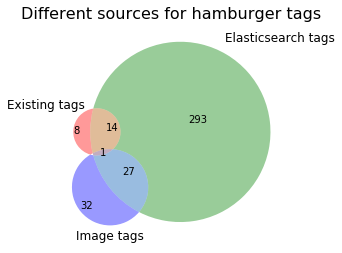

In [225]:
from matplotlib_venn import venn3
venn3([set(existing_tag_ids), set(elastic_tag_ids), set(image_tag_ids)], 
      set_labels = ('Existing tags', 'Elasticsearch tags', 'Image tags'))
plt.title("Different sources for hamburger tags", fontsize=16)

In [226]:
(
    restaurants_dedup
    .loc[lambda r: r['image'] & r['elastic'] & r['existing']]
)

,info_avg_price,info_city,info_country,info_house_number,info_lat,info_lon,info_name,info_postal_code,info_street,reviews_distinction,...,reviews_price_quality,reviews_rating_decor,reviews_rating_food,reviews_rating_service,reviews_rating,reviews_waiting_time,tags,existing,elastic,image
info_id,,,,,,,,,,,,,,,,,,,,,
259191,25,Amsterdam,Nederland,Vijzelstraat,52.359863,4.89126,Taproom,1017 HT,Nieuwe,Fantastisch,...,Gunstig,8.3,8.5,8.9,8.5,Kort,"[BBQ/grill, Terras, Romantisch, Aan het water,...",True,True,True


# Plot on map

In [246]:
import collections
Coords = collections.namedtuple('Coordinates', 'lat lon')
coords_gdd = Coords(lat=52.352379, lon=4.912933)

In [247]:
import geopy.distance
import folium
from folium.features import DivIcon

In [269]:
def plot_map(df, coords_center, range_in_km=1, min_rating=8, zoom_start=15):
    m = folium.Map(location=list(coords_center), zoom_start=zoom_start)

    for idx, row in df.iterrows():
        if row['reviews_rating_food'] < min_rating:
            continue
        if geopy.distance.vincenty(coords_center, (row['info_lat'], row['info_lon'])).km > range_in_km:
            continue
        for tag_type, color in zip(['existing', 'elastic', 'image'], ['#DDB997', '#99C799', '#99B7DA']):
            if row[tag_type]:
                folium.map.Marker([row['info_lat'], row['info_lon']], 
                                  icon=DivIcon(html=f'<div title="{row.info_name}", style="font-size: 15pt; display: inline-block; background-color: white; border-width: thick; border-style: solid; border-color:{color}";>{row.reviews_rating_food}</div>')
                                 ).add_to(m)

    folium.map.Marker(
        list(coords_center),
        icon=DivIcon(
            html='<div style="font-size: 15pt; display: inline-block; background-color:#5DBCD2; color:white; border-width: thin; border-style: solid; border-color:#5DBCD2"> GDD </div>',
            )
        ).add_to(m)
    return m

In [276]:
# Hoover over rating with mouse for restaurant name
plot_map(restaurants_dedup, coords_gdd, range_in_km=5, min_rating=9)